# Zillow Clustering Project
Sophia Stewart<br>
Stephanie Jones<br>
Codeup | Data Science, Hopper Cohort<br>
Monday, January 10, 2020

# About the Project
#### Goal
Identify drivers of error in predicting home value for single family properties<br>
#### Why?
We want to improve our zestimate home value predictions so that we can better serve those who purchase and sell homes<br>

# Data Dictionary
### DataFrames
| DFs | Meaning |
| :-------- | -------: |
| zillow   | Full, original dataframe retrieved from the zillow mySQL database |
| train    | Sample (56%) of zillow used for exploring data and fitting/training models|
| validate | Sample (24%) of zillow used to evaluate multiple models |
| test     | Sample (20%) of zillow used to evaluate the best model |

### Variables
| Target | Meaning |
| :-------- | -------: |
| logerror | Our target variable; the Zestimate error which we want to minimize |


| Variables | Meaning |
| :-------- | -------: |
| tax_value | The property's tax assessed value |
| beds     | Number of bedrooms |
| baths    | Number of bathrooms, including fractional bathrooms |
| fullbaths | Number of full bathrooms |
| latitude | The property's latitude |
| longitude | The property's longitude |
| sq_ft    | Calculated total finished living area |
| yearbuilt | The year the property was built |
| age      | The age of the property |
| transactiondate | The date the property was sold |

<!-- | Clustering | Meaning |
| :-------- | -------: |
| beds_scaled | Standard-scaled `beds` |
| baths_scaled | Standard-scaled `baths` |
| sq_ft_scaled | Standard-scaled `sq_ft` |


| Modeling | Meaning |
| :-------- | -------: |
| x_train  | `train`, with scaled `tax_value`, `age`, `sqft` columns |
| y_train  | `train`, but only the target |
| x_validate | `validate`, with scaled `tax_value`, `age`, `sqft` columns |
| y_validate | `validate`, but only the target |
| x_test   | `test`, with scaled `tax_value`, `age`, `sqft` columns |
| y_test   | `test`, but only the target | -->


# Executive Summary
High `logerror` threatens our credibility as a primary source of home valuation predictions in the real estate market. We want to find the drivers of Zestimate prediction `logerror` to provide more accurate home valuations. 
<br><br>
To do this, we will use clustering to identify patterns in our 2017 single-unit property data and use those clusters to build a model which will be used for predicting logerror. If we can predict `logerror`, we can use those predictions to make more accurate predictions of home values.

# Step 1 | Acquire and Wrangle
<hr>

In our `wrangle.py` module you will find the following functions:
- `acquire_zillow()` acquires zillow data from a csv file or from a sequel query (see query inside of function within module)
- `clean_zillow()` cleans the acquired data
    - filter out non-single unit properties using `propertylandusetypeid`, `beds`, `baths`, and `sqft`
    - drop null rows and columns with > 50% missing values
    - create `age` column from `yearbuilt`
    - drop any remaining null values
    - correct dtypes for int values
    - drop `propertylandusetypeid`, `transactiondate`, `yearbuilt`, `unitcnt`
    - remove outliers
- `split_zillow(df)` split data into train, validate, and test dfs


In [1]:
import warnings  
warnings.filterwarnings("ignore")

In [2]:
import wrangle as w

train, validate, test = w.split_zillow(w.clean_zillow(w.acquire_zillow()))

print(f'Train Shape: {train.shape}\nValidate Shape: {validate.shape}\nTest Shape: {test.shape}')

NumExpr defaulting to 8 threads.


Train Shape: (20184, 9)
Validate Shape: (6729, 9)
Test Shape: (6729, 9)


# Step 2 | Explore
<hr>

In our `explore.py` module you will find the following functions for exploration
- Univaratiate
    - `visualize_outliers():` two rows of boxplots, data before and after outliers removed
    - `var_distributions():` plots histograms of each of our variables
- Bivariate
- Multivariate

In [3]:
import explore_jones as e

## Univariate Exploration
##### Are there any extreme values in our outliers?

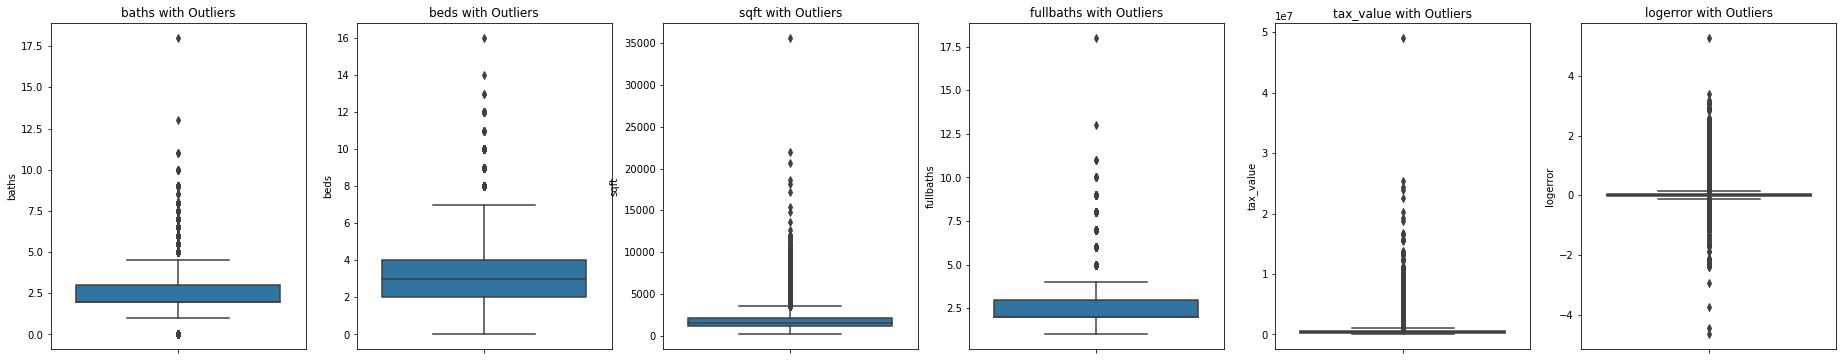

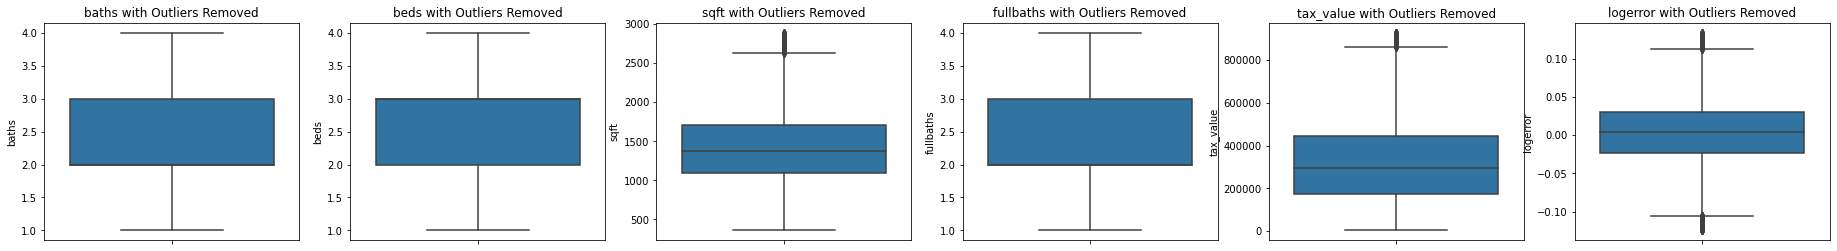

In [4]:
e.visualize_outliers(train)

>#### We can now actually see the IQR for `bath`, `sqft`, `fullbaths`, `tax_value` and `logerror`

##### What are the distributions for each of our variables?

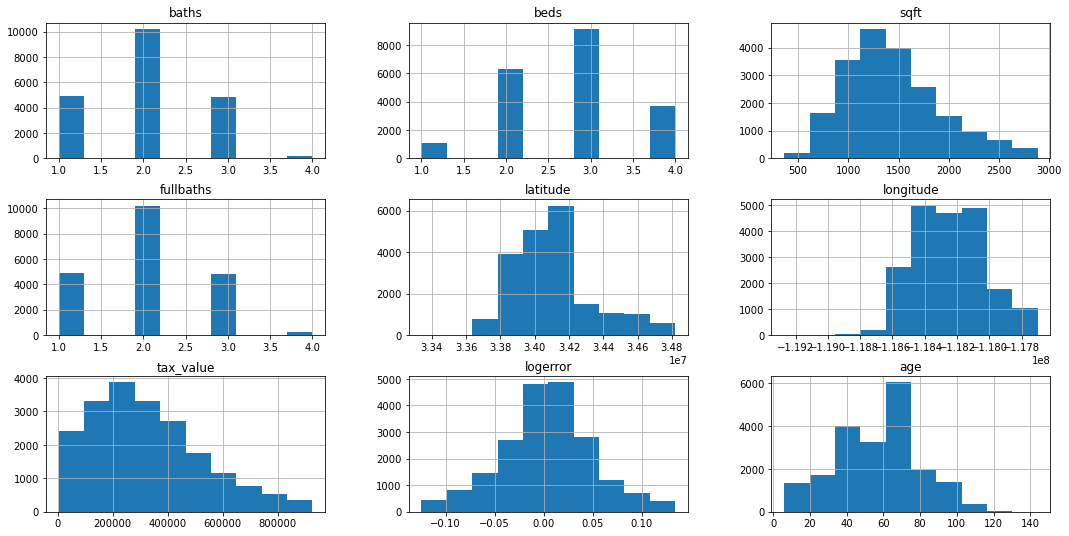

In [5]:
e.var_distributions(train)

>#### Normal
Our target variable, `logerror` is ~normally distrubuted.<br>`longitude` is also somewhat normally distrubuted. 

>#### Slightly Right Skewed 
`baths`, `fullbaths`, <br>`sqft`, <br>`latitude`, <br>`tax_value`, and <br>`age` 

>#### Slightly Left Skewed
`beds`

## Multivariate Exploration
##### How does each independent variable interact with the target?

In [6]:
target, ind_vars = e.plot_vars(train)

#### `logerror` is our target variable

In [7]:
# pd.DataFrame(train.columns, columns = ['target'])[7:8]
target.reset_index().drop(columns = ['index'])

,target
0,logerror


#### These are the independent variables we will be exploring.

In [8]:
# pd.DataFrame(train.columns, columns = ['independent_vars']).drop([7])
ind_vars

,independent_vars
0,baths
1,beds
2,sqft
3,fullbaths
4,latitude
5,longitude
6,tax_value
8,age


In [9]:
train.head(3)

,baths,beds,sqft,fullbaths,latitude,longitude,tax_value,logerror,age
24277,2.0,2,763,2,33823600,-118342000,327000.0,-0.005293,20.0
10231,2.0,4,1171,2,34280592,-118425818,353000.0,-0.011207,66.0
63485,2.0,3,1108,2,34097291,-117999167,39503.0,0.009146,58.0


### Q1. Does age affect home value? 
We think older homes will be least expensive and newer homes will be most expensive.

**Age Bins**
- `our_age` < 40
- 40 < `parents_age` < 75
- 75 < `gma_age` < 110
- 110 < `greatg_age` 

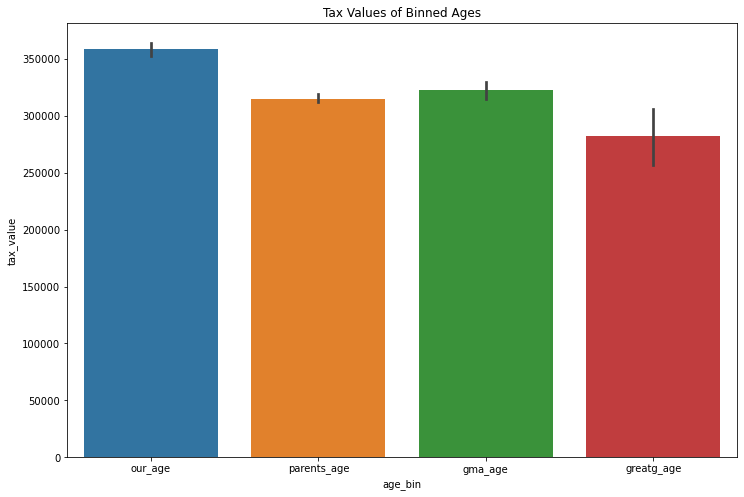

Reject H(o) | There is a statistically significant difference between the means of the youngest and oldest homes.


In [10]:
e.age_home(train)

# *Scripting*
### Hypothesis Test | Older vs. Newer Home Mean Values
We ran a `two_tailed`, `ind` hypothesis test to see if there was a statistically significant difference between the newer homes's mean value and older homes' mean value.
>**Two tailed:** We are looking for any difference, greater or less than, between means <br>
**Two sample:** We are comparing means across 2 samples of our data <br>
Large enough dataset that we do not need to test for `equal_var`

$Ho$: There is no statistically significant difference between the newer and older homes' mean value. <br>
$Ha$: There is no statistically significant difference between the newer and older homes' mean value. <br>
$α$ = .05 
- *If $α$ < **p** value, then we fail to reject* $Ho$)<br>

>As expected, older homes had least expensive mean value and newer homes had the most expensive mean value, but there did not appear to be a significant difference in the mean home values across each age bin.
- The two bins in the middle were almost equal, with the older bin having a slightly more expensive mean value.
- There is a There is a statistically significant difference between the means of the youngest and oldest homes.

### Q2 Do homes in certain locations have higher home values?
We think we can use our features to create some clusters to create a geoplot and explore home values by location.
##### Cluster Features
- `beds`
- `baths`
- `sqft`

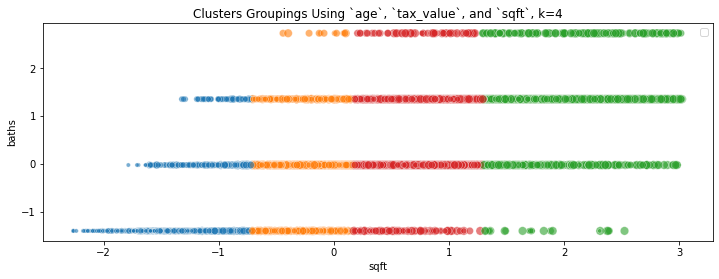

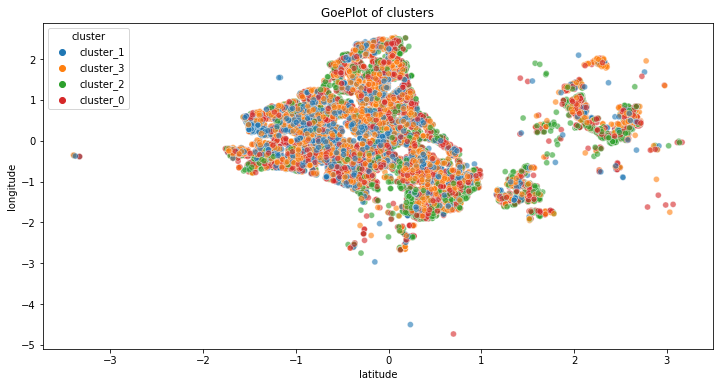

No Meaningful Patterns In Clusters When Plotted Geographically


In [11]:
X_train_scaled, X_validate_scaled, X_test_scaled = e.cluster_and_scale(train, validate, test)

## Multivariate Exploration using Clustering

#### Are there any interesting patterns when the data is plotted geographically?

In [12]:
# cluster_cols = ['beds', 'baths', 'sqft']

In [13]:
# for colu in cluster_cols:
#     sns.relplot(data = train, x = 'latitude', y = 'longitude', hue = colu, col = 'cluster')
#     plt.title(f'{colu} Plotted Geographically')
#     plt.show()

# Exploration Takeaways 
- `age` would be a good model feature

# Conclusion
>Your conclusion summary should addresses the questions you raised in the opening of the project, which we would want to see at the end of every final notebook. Ideally, when the deliverable is a report, the summary should tie together your analysis, the drivers of the outcome, and how you would expect your ML model to perform in the future on unseen data, in layman's terms.

## Recommendations
>Your notebook should end with actionable recommendations based on your insights and analysis on a way to make a better model, such as a new feature or an algorithm or something you found that doesn't work.

## Next Steps
>Your conclusion should include next steps from a data science perspective that will assist in improving your research. Ideally, if you talk about trying more algorithms to improve performance, think about why you need to improve performance. And if the business calls for it, remember the best way to improve performance is to have better predictors/features. If you talk about gathering more data, being specific about what data you think will help you understand the problem better and why is the way to go!